<a href="https://colab.research.google.com/github/AbeerAbuZayed/QUIUG_Hate-Speech-Detection_OSACT4-Workshop/blob/master/%5BPart_1%5DHate-Speech-Detection_Classical-ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Part 1] Hate Speech Detection Using Classical Machine Learning
In this notebook, we conduct a preliminary experiment on the detection of hate speech in Arabic tweets as part of our participation in the Hate Speech Detection subtask in [OSACT4 workshop](http://edinburghnlp.inf.ed.ac.uk/workshops/OSACT4/)

# 1. Data Loading and Basic Data Exploration
In this section, we are going to load the train and dev dataset avaliable on the [workshop website](http://edinburghnlp.inf.ed.ac.uk/workshops/OSACT4/) and conduct basic data exploration for a basic understanding of the data.
*   [Train dataset](https://edinburghnlp.inf.ed.ac.uk/workshops/OSACT4/datasets/OSACT2020-sharedTask-train.txt)
*   [Dev dataset](https://edinburghnlp.inf.ed.ac.uk/workshops/OSACT4/datasets/OSACT2020-sharedTask-dev.txt)



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import re
import string
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as creport


from multiprocessing import Pool

NOTE: the data files used in this experiment are CSV files (the original txt files are converted to CSV files).

### **Loading Data**

In [0]:
train_data = pd.read_csv('train_data.csv')
train_data.head()

,Tweet,Offensive,Hate
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF,HS
3,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT_OFF,NOT_HS


In [0]:
dev_data = pd.read_csv('dev_data.csv')
dev_data.head()

,Tweet,Offensive,Hate
0,فى حاجات مينفعش نلفت نظركوا ليها زى الاصول كده...,NOT_OFF,NOT_HS
1,RT @USER: وعيون تنادينا تحايل فينا و نقول يا ع...,NOT_OFF,NOT_HS
2,يا بلادي يا أم البلاد يا بلادي بحبك يا مصر بحب...,NOT_OFF,NOT_HS
3,RT @USER: يا رب يا قوي يا معين مدّني بالقوة و ...,NOT_OFF,NOT_HS
4,RT @USER: رحمك الله يا صدام يا بطل ومقدام. URL,NOT_OFF,NOT_HS


In [0]:
print("Train data shape:{} \nDev data shape: {}".format(train_data.shape,dev_data.shape))


Train data shape:(7000, 3) 
Dev data shape: (1000, 3)


### **Checking Missing Values**

In [0]:
train_data.isnull().sum()

Tweet        0
Offensive    0
Hate         0
dtype: int64

In [0]:
dev_data.isnull().sum()

Tweet        0
Offensive    0
Hate         0
dtype: int64

There are no missing values in both train and dev dataset.

### **HS class distribution in train and dev dataset**

In [0]:
train_data['Hate'].value_counts()

NOT_HS    6639
HS         361
Name: Hate, dtype: int64

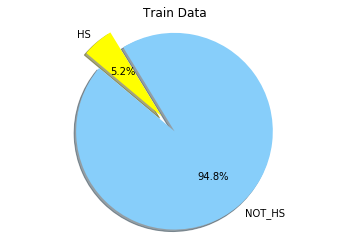

In [0]:
# Data to plot
labels = 'NOT_HS', 'HS'
sizes = [train_data['Hate'].value_counts()[0], train_data['Hate'].value_counts()[1]]
colors = ['lightskyblue', 'yellow']
explode = (0,0.2)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Train Data")
plt.show()

*   There are 7,000 training tweets, only 361 of them (5.2%) are labelled as hate speech. 

In [0]:
dev_data['Hate'].value_counts()

NOT_HS    956
HS         44
Name: Hate, dtype: int64

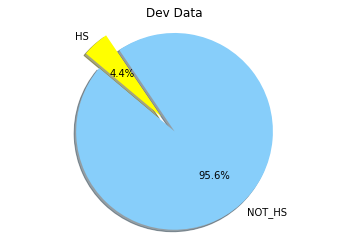

In [0]:
# Data to plot
labels = 'NOT_HS', 'HS'
sizes = [dev_data['Hate'].value_counts()[0], dev_data['Hate'].value_counts()[1]]
colors = ['lightskyblue', 'yellow']
explode = (0,0.2)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Dev Data")
plt.show()

*   There are 1,000 dev tweets, only 44 of them (4.4%) are labelled as hate speech.

**This shows how the two classes in the dataset are clearly imbalanced.** 

# 2. Data Cleaning
To prepare our dataset for the feature extraction process, basic text preprocessing is done as follows:

In [0]:
def clean(df):
    df = remove_diacritics(df)
    df = normalize_arabic(df)
    df = remove_punctuations(df)
    df = remove_repeating_char(df)
    df= remove_english_word_and_numbers(df)
    df=clean_space(df)
    return df

In [0]:
arabic_punctuations = '''`÷« »×؛<>٩٨'٧٦٥٤٣٢١٠_()↗*•&^%][ـ،/:"؟.,'{}⋮≈~¦+|٪!”…“–ـ/[]%=#*+\\•~@£·_{}©^®`→°€™›♥←×§″′Â█à…“★”–●â►−¢¬░¶↑±▾	═¦║―¥▓—‹─▒：⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡₹´'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


In [0]:
def remove_diacritics(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_diacritics(x))
    return df
def _remove_diacritics(x):
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _normalize_arabic(x))
    return df
def _normalize_arabic(x):
    x = str(x)
    # added space around puncts after replace
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)
    return x

def remove_punctuations(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_punctuations(x))
    return df
def _remove_punctuations(x):
    x = str(x)
    #translator = str.maketrans(' ', ' ', punctuations_list)
    translator = str.maketrans(punctuations_list, ' '*len(punctuations_list))
    return x.translate(translator)

def remove_repeating_char(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_repeating_char(x))
    return df
def _remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)

def remove_english_word_and_numbers(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_english_word_and_numbers(x))
    return df
def _remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

def clean_space(df):
    compiled_re = re.compile(r"\s+")
    df['Tweet'] = df["Tweet"].apply(lambda x: _clean_space(x, compiled_re))
    return df
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)


In [0]:
num_cores = 2
def df_parallelize_run(df, func, num_cores=2):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [0]:
train_data_cleaned = df_parallelize_run(train_data, clean)

In [0]:
#train_data_cleaned.to_csv("train_data_cleaned.csv", index=False)    #save the train_data_cleaned dataframe to csv

In [0]:
#!cp -R train_data_cleaned.csv "/content/drive/My Drive/OSACT4"            #save the csv file to the drive


In [0]:
dev_data_cleaned = df_parallelize_run(dev_data, clean)

In [0]:
#dev_data_cleaned.to_csv("dev_data_cleaned.csv", index=False)

In [0]:
#!cp -R dev_data_cleaned.csv "/content/drive/My Drive/OSACT4"

# 3. Classical Machine Learning Algorithms with tf- idf
We experimented with various classical machine learning models:

1.  SVM
2.  Random Forest
3.  XGBoost
4.  Extra Trees
5.  Decision Trees
6.  Gradient Boosting
7.  Logistic Regression









In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/OSACT4/train_data_cleaned.csv')

In [0]:
x=dataset.iloc[:,0]
y=dataset.iloc[:,2]
X=x.to_dict()

X=[]
for d in range(len(x)):
    b=x[d]
    X.append(b) 

In [0]:
count_vect=CountVectorizer()
X_train_counts=count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf= X_train_tfidf.toarray()

In [0]:
print(X_train_tfidf.shape)

(7000, 28701)



## SVM Classifier

In [0]:
from sklearn.svm import SVC
clf= SVC(random_state = 0)
clf.fit(X_train_tfidf, y)
clf.score(X_train_tfidf, y)

In [0]:
dev_data = pd.read_csv('/content/drive/My Drive/OSACT4/dev_data_cleaned.csv')


In [0]:
x_dev=dev_data.iloc[:,0]
y_dev=dev_data.iloc[:,2]
#X=x_dev.to_dict()

X=[]
for d in range(len(x)):
    b=x[d].lower()
    X.append(b)  

In [0]:
X_dev_tfidf=count_vect.transform(x_dev)


In [0]:
y_pred=clf.predict(X_dev_tfidf)

In [0]:
print(creport(y_dev, y_pred,target_names=['HS', 'NOT_HS'],digits=4))


              precision    recall  f1-score   support

          HS     0.0000    0.0000    0.0000        44
      NOT_HS     0.9560    1.0000    0.9775       956

    accuracy                         0.9560      1000
   macro avg     0.4780    0.5000    0.4888      1000
weighted avg     0.9139    0.9560    0.9345      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Classifier


In [0]:
from sklearn import model_selection, naive_bayes, svm, ensemble, tree
from xgboost import XGBClassifier


In [0]:
RF= ensemble.RandomForestClassifier()
RF.fit(X_train_tfidf, y)
RF.score(X_train_tfidf, y)

1.0

In [0]:
x_dev=dev_data.iloc[:,0]
y_dev=dev_data.iloc[:,2]
X=x_dev.to_dict()

X=[]
for d in range(len(x)):
    b=x[d].lower()
    X.append(b)

X_dev_tfidff=count_vect.transform(x_dev)
y_pred=RF.predict(X_dev_tfidf)

In [0]:
print(creport(y_dev, y_pred,target_names=['HS', 'NOT_HS'] ,digits=4))


              precision    recall  f1-score   support

          HS     0.9000    0.2045    0.3333        44
      NOT_HS     0.9646    0.9990    0.9815       956

    accuracy                         0.9640      1000
   macro avg     0.9323    0.6017    0.6574      1000
weighted avg     0.9618    0.9640    0.9530      1000



## XGB Classifier

In [0]:
XGB= XGBClassifier()
XGB.fit(X_train_tfidf, y)
XGB.score(X_train_tfidf, y)

0.9554285714285714

In [0]:
x_dev=dev_data.iloc[:,0]
y_dev=dev_data.iloc[:,2]
X=x_dev.to_dict()

X=[]
for d in range(len(x)):
    b=x[d].lower()
    X.append(b)

X_dev_tfidf=count_vect.transform(x_dev)
y_pred=XGB.predict(X_dev_tfidf)

In [0]:
print(creport(y_dev, y_pred,target_names=['HS', 'NOT_HS'],digits=4))


              precision    recall  f1-score   support

          HS     0.0000    0.0000    0.0000        44
      NOT_HS     0.9560    1.0000    0.9775       956

    accuracy                         0.9560      1000
   macro avg     0.4780    0.5000    0.4888      1000
weighted avg     0.9139    0.9560    0.9345      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Extra Trees Classifier

In [0]:
extrees= ensemble.ExtraTreesClassifier()
extrees.fit(X_train_tfidf, y)
extrees.score(X_train_tfidf, y)

1.0

In [0]:
x_dev=dev_data.iloc[:,0]
y_dev=dev_data.iloc[:,2]
X=x_dev.to_dict()

X=[]
for d in range(len(x)):
    b=x[d].lower()
    X.append(b)

X_dev_tfidf=count_vect.transform(x_dev)
y_pred=extrees.predict(X_dev_tfidf)

In [0]:
print(creport(y_dev, y_pred,target_names=['HS', 'NOT_HS'],digits=4))


              precision    recall  f1-score   support

          HS     0.6667    0.2727    0.3871        44
      NOT_HS     0.9674    0.9937    0.9804       956

    accuracy                         0.9620      1000
   macro avg     0.8170    0.6332    0.6837      1000
weighted avg     0.9542    0.9620    0.9543      1000



## Decision Tree Classifier

In [0]:
DTC= tree.DecisionTreeClassifier()
DTC.fit(X_train_tfidf, y)
DTC.score(X_train_tfidf, y)

1.0

In [0]:
x_dev=dev_data.iloc[:,0]
y_dev=dev_data.iloc[:,2]
X=x_dev.to_dict()

X=[]
for d in range(len(x)):
    b=x[d].lower()
    X.append(b)

X_dev_tfidf=count_vect.transform(x_dev)
y_pred=DTC.predict(X_dev_tfidf)

In [0]:
print(creport(y_dev, y_pred,target_names=['HS', 'NOT_HS'],digits=4))


              precision    recall  f1-score   support

          HS     0.1565    0.4091    0.2264        44
      NOT_HS     0.9706    0.8985    0.9332       956

    accuracy                         0.8770      1000
   macro avg     0.5636    0.6538    0.5798      1000
weighted avg     0.9348    0.8770    0.9021      1000



## Gradient Boosting Classifier

In [0]:
GBC= ensemble.GradientBoostingClassifier()
GBC.fit(X_train_tfidf, y)
GBC.score(X_train_tfidf, y)

0.9628571428571429

In [0]:
x_dev=dev_data.iloc[:,0]
y_dev=dev_data.iloc[:,2]
X=x_dev.to_dict()

X=[]
for d in range(len(x)):
    b=x[d].lower()
    X.append(b)

X_dev_tfidf=count_vect.transform(x_dev)
y_pred=GBC.predict(X_dev_tfidf)

In [0]:
print(creport(y_dev, y_pred,target_names=['HS', 'NOT_HS'],digits=4))


              precision    recall  f1-score   support

          HS     0.8182    0.2045    0.3273        44
      NOT_HS     0.9646    0.9979    0.9810       956

    accuracy                         0.9630      1000
   macro avg     0.8914    0.6012    0.6541      1000
weighted avg     0.9582    0.9630    0.9522      1000



## Logistic Regression Classifier

In [0]:
from sklearn import linear_model

In [0]:
LR= linear_model.LogisticRegression()
LR.fit(X_train_tfidf, y)
LR.score(X_train_tfidf, y)

0.9484285714285714

In [0]:
x_dev=dev_data.iloc[:,0]
y_dev=dev_data.iloc[:,2]
X=x_dev.to_dict()

X=[]
for d in range(len(x)):
    b=x[d].lower()
    X.append(b)

In [0]:
X_dev_tfidf=count_vect.transform(x_dev)


In [0]:
y_pred=LR.predict(X_dev_tfidf)


In [0]:
print(creport(y_dev, y_pred,target_names=['HS', 'NOT_HS'],digits=4))


              precision    recall  f1-score   support

          HS     0.3750    0.0682    0.1154        44
      NOT_HS     0.9587    0.9948    0.9764       956

    accuracy                         0.9540      1000
   macro avg     0.6668    0.5315    0.5459      1000
weighted avg     0.9330    0.9540    0.9385      1000



#4. Classical Machine Learning Algorithms with Word Embeddings

Go to: [Colab Notebook](https://colab.research.google.com/drive/1Yk12Ng68RJ5Mn24vHgNg-nEdznIEDArZ)